<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm ## progress bar

In [10]:
## get data from github
df = pd.read_csv("https://raw.githubusercontent.com/Frederick-Stein/Data-Science-Playground/refs/heads/main/ToyModels/Sentiment_Analysis/preprocessed_data.csv")
df.head(10)
sentences = df['able play youtube alexa']
labels = df['0.5']
labels = torch.tensor(labels.values, dtype=torch.float32)
labels.shape

torch.Size([4083])

In [11]:
torch.manual_seed(42)
## prepare encoded data
def prepare_data(sentences):

    words = set()
    for sentence in sentences:
        for word in sentence.split():
            words.add(word)

    token_to_id = {"<PAD>": 0, "<EOS>": 1}
    id_to_token = {0: "<PAD>", 1: "<EOS>"}
    for i, word in enumerate(words, start = 2):
        token_to_id[word] = i
        id_to_token[i] = word

    vocab_size = len(token_to_id)

    def encode(sentence):
        ids = []
        for word in sentence.split():
            ids.append(token_to_id[word])
        return ids

    encoded_sentences = [torch.tensor(encode(sentence)) for sentence in sentences]
    padded_sentences =  nn.utils.rnn.pad_sequence(encoded_sentences, batch_first=True, padding_value=0)
    return vocab_size, padded_sentences, token_to_id, id_to_token

In [12]:
## prepare data
vocab_size, input, token_to_id, id_to_token = prepare_data(sentences)
output = labels.unsqueeze(1)
dataset = TensorDataset(input, output)

## get train_data and test_data
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

## set dataloader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
## construct function
class EmotionPredictor(nn.Module):

    def __init__(self, vocab_size, d_model):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.linear = nn.Linear(d_model, 1)
        self.tanch = nn.Tanh()

    def forward(self, x):

        embedding = self.embedding(x)
        averaged = torch.mean(embedding, dim = 1)
        full_layer = self.linear(averaged)
        output = self.tanch(full_layer)
        return output

In [14]:
## test model
model = EmotionPredictor(vocab_size, 256)
X0, y0 = next(iter(train_loader))
output = model(X0)
output.shape

torch.Size([64, 1])

In [18]:
## training process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionPredictor(vocab_size, 256).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)

train_error = []
# train_accuracy = []
test_error = []
# test_accuracy = []

Epochs = 100
for epoch in tqdm(range(1, Epochs + 1)):
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_error.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_error.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

 11%|█         | 11/100 [00:01<00:11,  7.67it/s]

Epoch 10, Train Loss: 0.1104, Test Loss: 0.1093


 21%|██        | 21/100 [00:02<00:10,  7.85it/s]

Epoch 20, Train Loss: 0.0910, Test Loss: 0.0961


 31%|███       | 31/100 [00:04<00:08,  7.90it/s]

Epoch 30, Train Loss: 0.0824, Test Loss: 0.0892


 41%|████      | 41/100 [00:05<00:07,  7.51it/s]

Epoch 40, Train Loss: 0.0759, Test Loss: 0.0837


 51%|█████     | 51/100 [00:06<00:06,  7.95it/s]

Epoch 50, Train Loss: 0.0711, Test Loss: 0.0794


 61%|██████    | 61/100 [00:07<00:05,  7.75it/s]

Epoch 60, Train Loss: 0.0666, Test Loss: 0.0763


 70%|███████   | 70/100 [00:09<00:05,  5.07it/s]

Epoch 70, Train Loss: 0.0629, Test Loss: 0.0742


 81%|████████  | 81/100 [00:12<00:03,  6.24it/s]

Epoch 80, Train Loss: 0.0613, Test Loss: 0.0736


 91%|█████████ | 91/100 [00:13<00:01,  7.38it/s]

Epoch 90, Train Loss: 0.0590, Test Loss: 0.0723


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]

Epoch 100, Train Loss: 0.0601, Test Loss: 0.0715


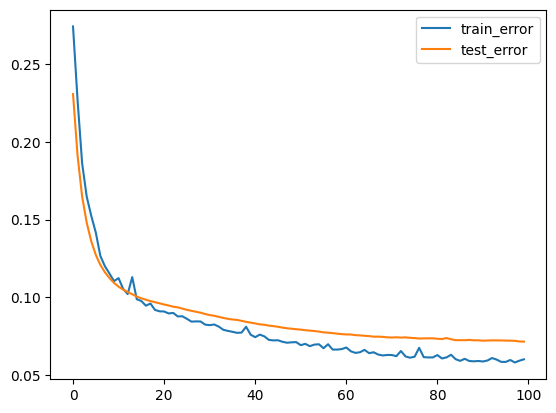

In [19]:
plt.plot(train_error, label="train_error")
plt.plot(test_error, label="test_error")
plt.legend()
plt.show()

In [31]:
test1 = "echo dot not work pls provide service center detail"
test2 = 'best thing ever'
test3 = "i dont like this movie"
test4 = "weird but funny movie"
test = [test1, test2, test3, test4]

encoded_test = []
for sentence in test:
    ids = []
    for word in sentence.split():
        if word in token_to_id:
            ids.append(token_to_id[word])
        else:
            ids.append(0)
    encoded_test.append(torch.tensor(ids))

padded_test = nn.utils.rnn.pad_sequence(encoded_test, batch_first=True, padding_value=0)
padded_test = padded_test.to(device)
with torch.inference_mode():
    output = model(padded_test)

print(output.tolist())

[[-0.9991450905799866], [0.999995768070221], [-0.5543029308319092], [0.11358121782541275]]
